# Visualization of the models

In [1]:
from venn import venn, pseudovenn
import cobra
from libsbml import *
import refinegems as rg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PARAMS import *

STRAINS = {'fda_1054':'TS', 
            'fda_1197':'1197',
            'fda_1115':'1115',
            'fda_1116':'1116',
            'KC_Na_01':'KC',
            }
STRAINS_LAB = {'14':'TS', 
            '15':'1197',
            '16':'1115',
            '17':'1116',
            }
MEDIA = {'CGXlab':'CGXII'}

In [ ]:
models = ['../../models/Cstr_TS.xml','../../models/Cstr_1197.xml', '../../models/Cstr_1115.xml','../../models/Cstr_1116.xml','../../models/Cstr_KC-Na-01.xml']
cmods = [rg.io.load_model_cobra(mod) for mod in models]
mods = [rg.io.load_model_libsbml(mod) for mod in models] 

## SBO Terms bar chart

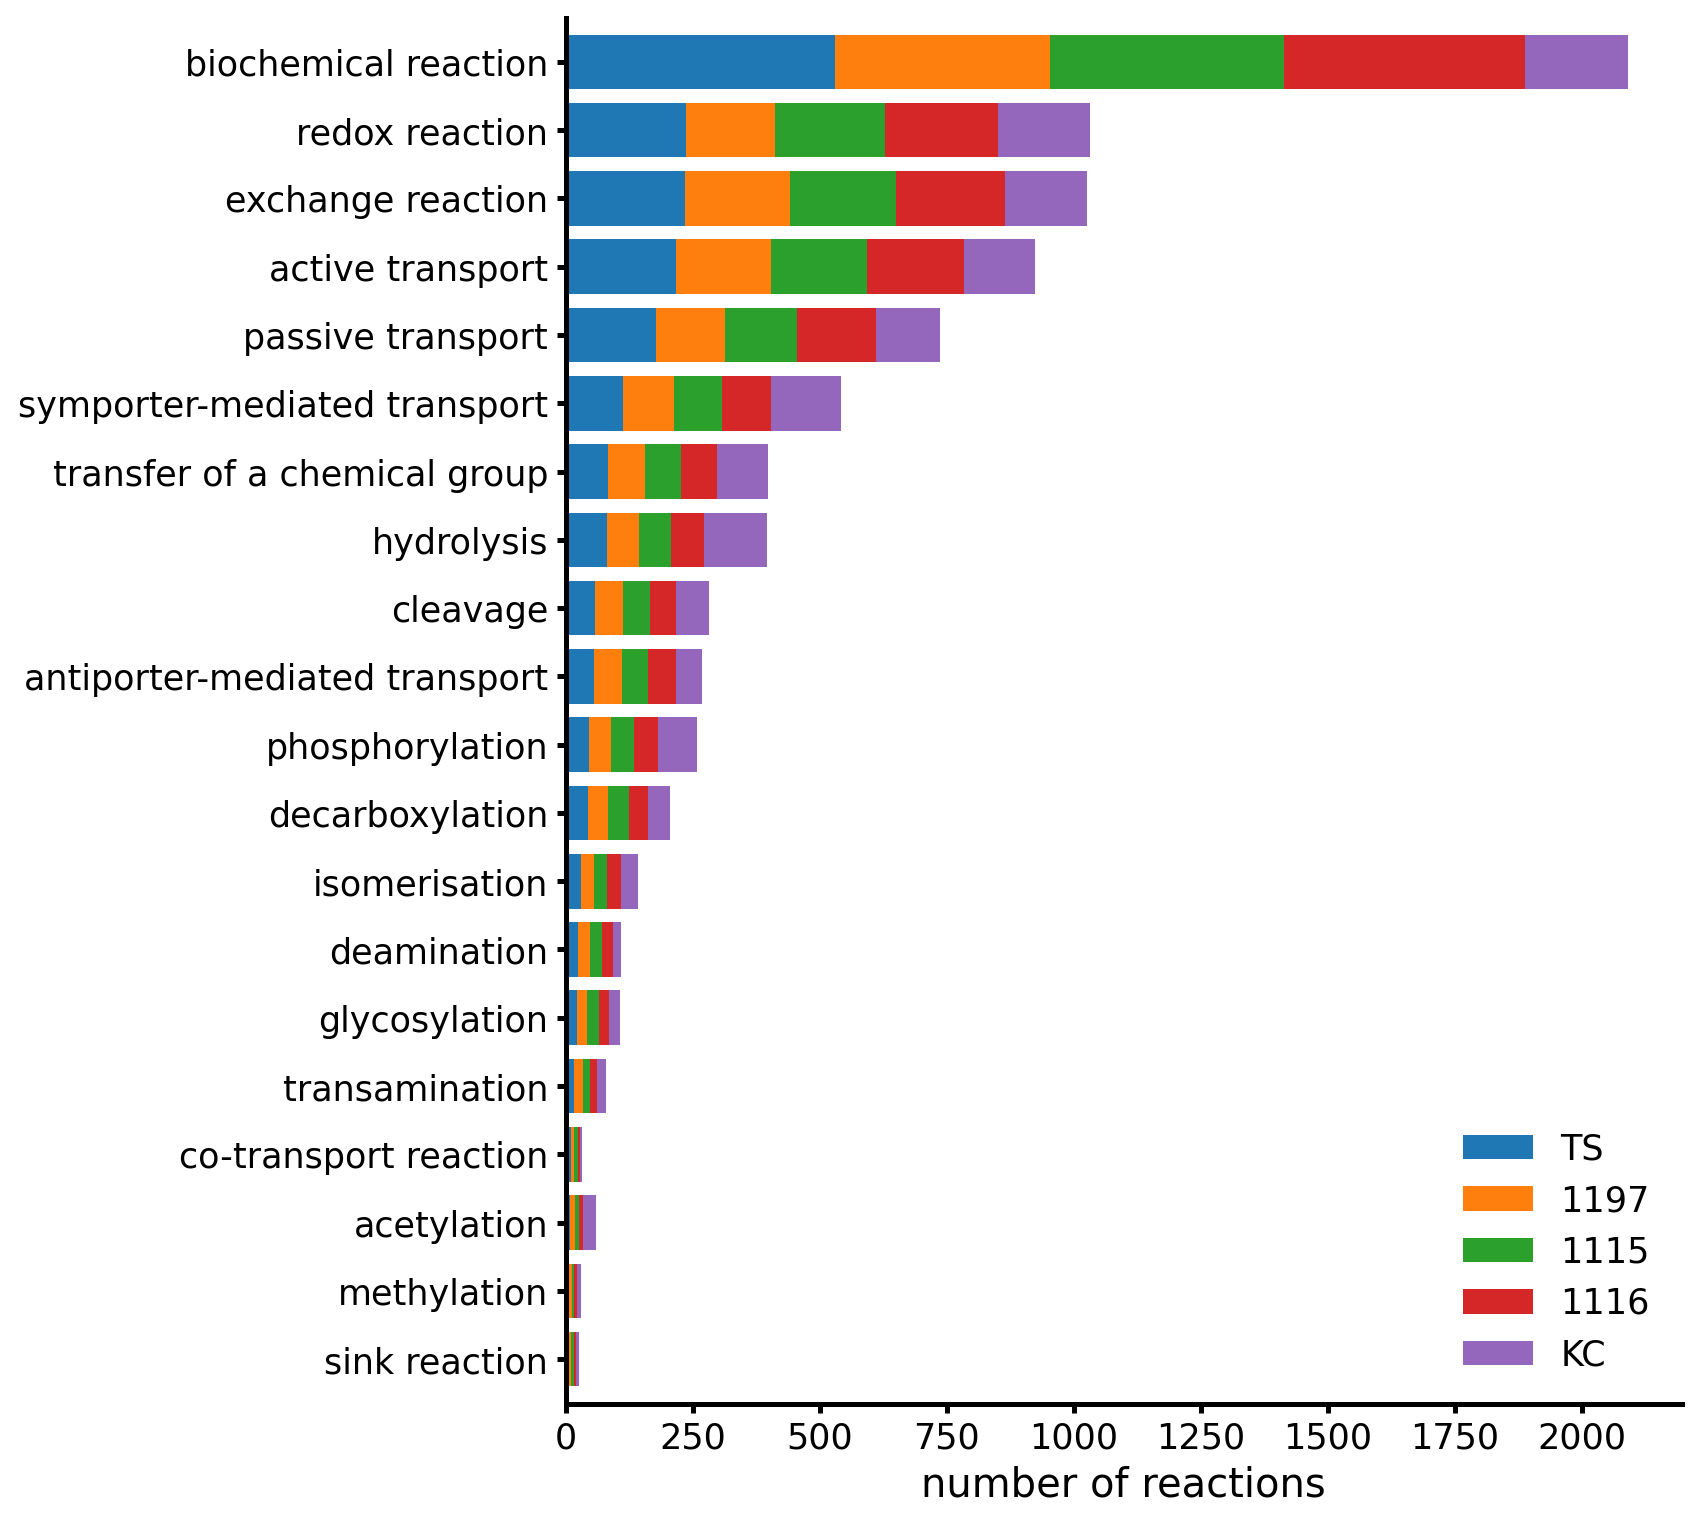

In [40]:
rg.comparison.plot_rea_sbo_multiple(mods, STRAINS)
plt.savefig('../../analysis/comparison/all_ReacPerSBO.png', bbox_inches='tight')

## Venn diagrams to show metabolite and reaction overlap

In [3]:
with plt.rc_context({'font.size': 25}):
    name = 'metabs'
    fig = rg.comparison.plot_venn(cmods, 'metabolite', True, STRAINS)
    plt.tight_layout()
    plt.savefig('../../analysis/comparison/' + name + '.png',bbox_inches='tight')

    name = 'reac'
    fig = rg.comparison.plot_venn(cmods, 'reaction', True, STRAINS)
    plt.tight_layout()
    plt.savefig('../../analysis/comparison/' + name + '.png',bbox_inches='tight')

plt.close('all')

## Numbers

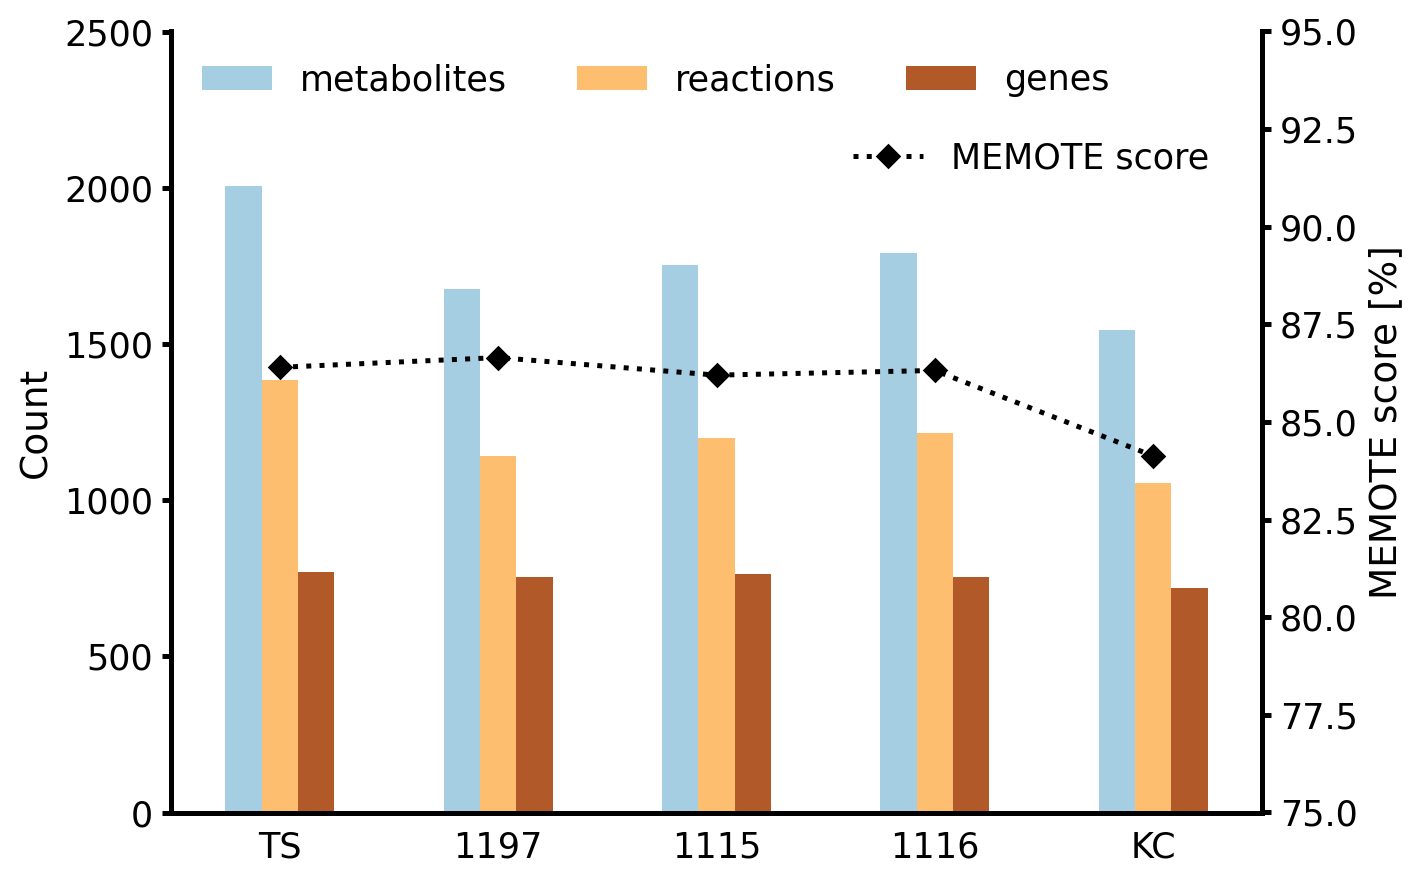

In [12]:
numbers = pd.DataFrame(['reactions', 'metabolites', 'genes'])

for model in cmods:
    numbers[STRAINS[model.id]] = [len(model.metabolites), 
                                  len(model.reactions), 
                                  len(model.genes)]

numbers.loc[3,:] = ['MEMOTE score', 86.40, 86.65, 86.20, 86.32, 84.13]


with plt.rc_context({"axes.spines.right" : True}):
    ax = numbers.set_index(0).T.plot.bar(y=['metabolites', 'reactions', 'genes'], figsize=(8, 5), cmap='Paired')
    numbers.set_index(0).T.plot(y='MEMOTE score', ax=ax, use_index=False, linestyle=':', secondary_y='MEMOTE score', color='k', marker='D', legend=True)
    ax.right_ax.set_ylabel('MEMOTE score [%]', fontsize=15)
    ax.right_ax.legend(loc='upper right', bbox_to_anchor=[0.98, 0.9])
    ax.legend(title=False, loc='upper left', ncol=3)
    ax.right_ax.set_ylim([75, 95])
    ax.set_ylim([0,2500])
    ax.tick_params(axis='x',which='both', bottom=False,top=False)
    ax.set_ylabel('Count', fontsize=15)
    plt.tight_layout()
    plt.savefig('../../analysis/comparison/numbers.png')

## Heatmaps

### Simulated doubling times

In [38]:
growth = pd.read_csv('../../analysis/growth_sim_comp/growth_20230113_minimal_uptake.csv')[['model', 'medium', 'doubling_time [min]']]
growth=growth.set_index(['medium', 'model']).sort_index().T.stack()
growth.columns.name=None
growth.index.names = (None,None)
growth.index.name=None
growth.index = growth.index.get_level_values(1)
growth.replace([np.inf, -np.inf], np.nan, inplace=True)
growth.drop('SNM3', inplace=True, axis=1)
growth.rename(STRAINS, inplace=True)
growth.rename(MEDIA, axis=1, inplace=True)
growth = growth.T[['TS', '1197', '1115', '1116', 'KC']].T
growth

,CGXII,LB,M9,RPMI
TS,75.816170,57.823952,75.805153,60.018017
1197,75.200324,59.679991,75.189307,61.914130
1115,74.434812,50.336479,74.423795,55.771299
1116,NaN,50.624434,NaN,52.638258
KC,46.838273,27.682989,46.815811,NaN


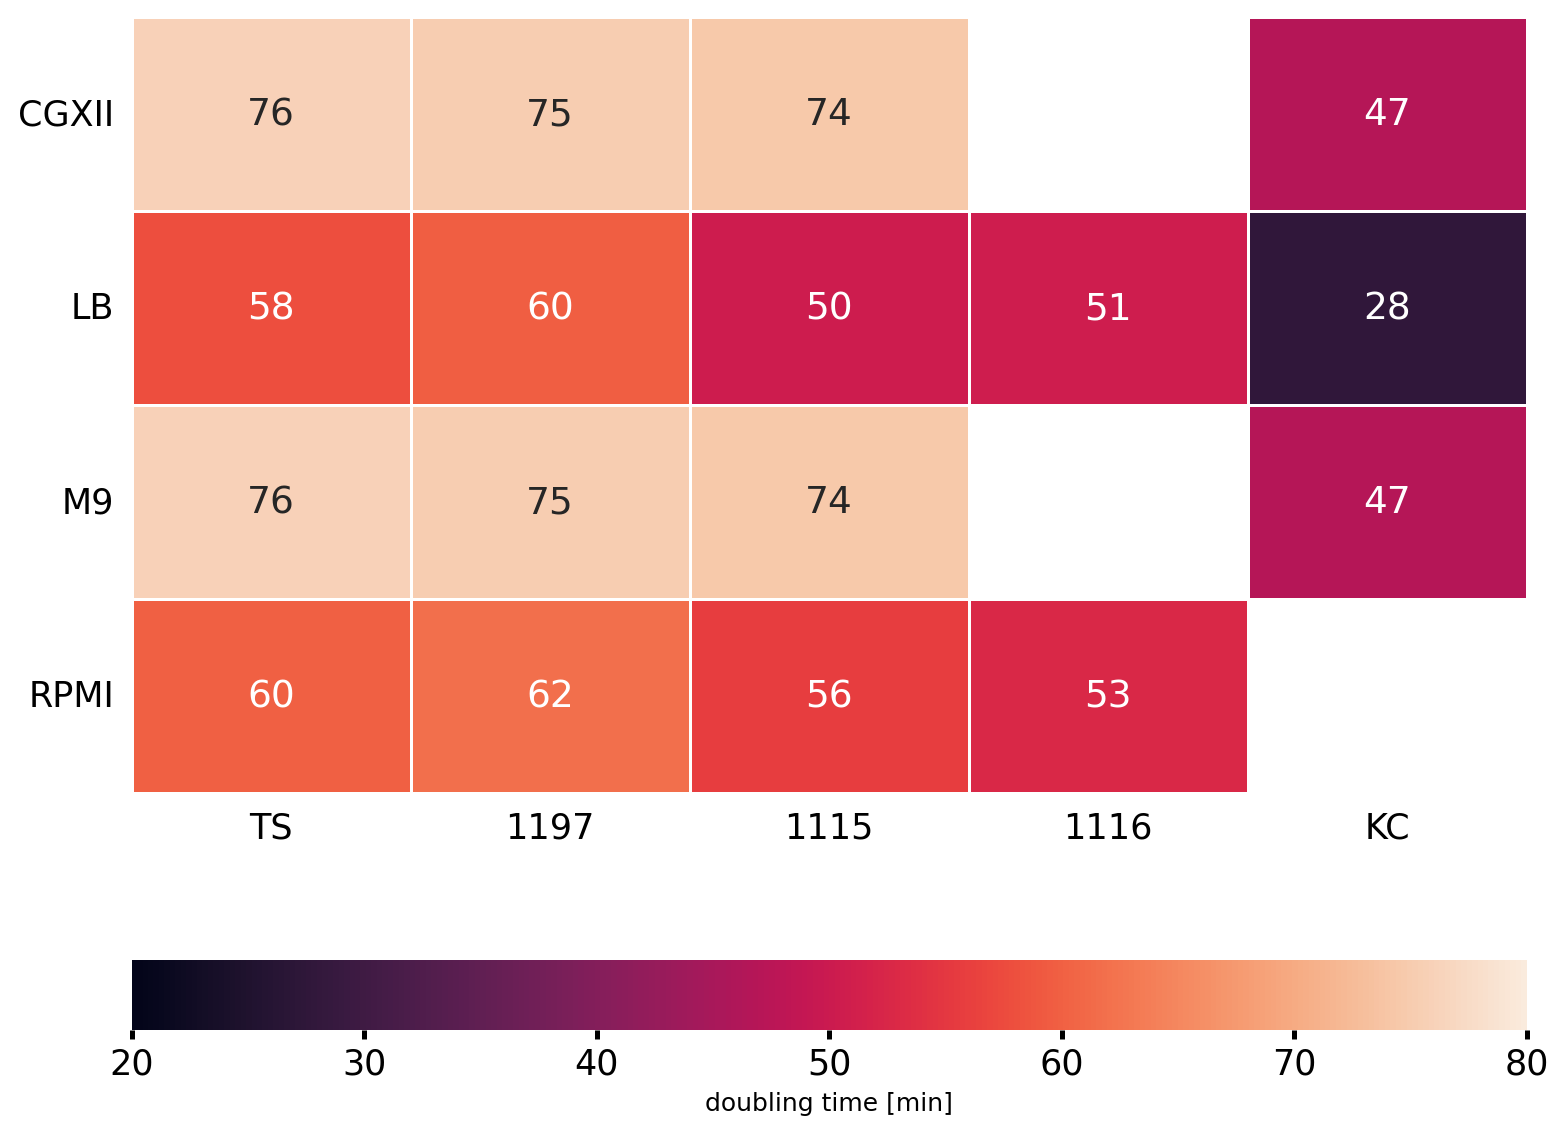

In [39]:
plt.figure(figsize=(10,8))
sns.heatmap(growth.T, 
            annot=True, 
            annot_kws={"fontsize":15},
            vmin=20, vmax=80,
            #cmap='crest', 
            linewidth=.5, 
            cbar_kws = {'orientation':'horizontal', 'label':'doubling time [min]'},
            )
plt.tick_params(rotation=0, bottom=False, top=False, left=False, right=False)
plt.savefig('../../analysis/comparison/heatmap_dt.png', bbox_inches='tight')

### Ability to grow on plain medium

In [30]:
conf = pd.read_excel('/Users/baeuerle/Organisation/Masterarbeit/Nextcloud/master_thesis/paper/Cstr V4/results_V4.xlsx', sheet_name='in silico').replace({'yes':1,'no':0})#.set_index('base')
s = conf[conf['data'] == 'growth on plain medium '].set_index('base').drop('data', axis=1)
conf = pd.read_excel('/Users/baeuerle/Organisation/Masterarbeit/Nextcloud/master_thesis/paper/Cstr V4/results_V4.xlsx', sheet_name='in vitro').replace({'yes':1,'no':0})#.set_index('base')
v = conf[conf['data'] == '24h-OD-fold-change > 2'].set_index('base').drop('data', axis=1)
con = pd.DataFrame(v == s)
con

,TS,1197,1115,1116
base,,,,
LB,True,True,True,False
M9,True,True,False,True
RPMI,False,False,False,False
CGXII,False,True,False,True


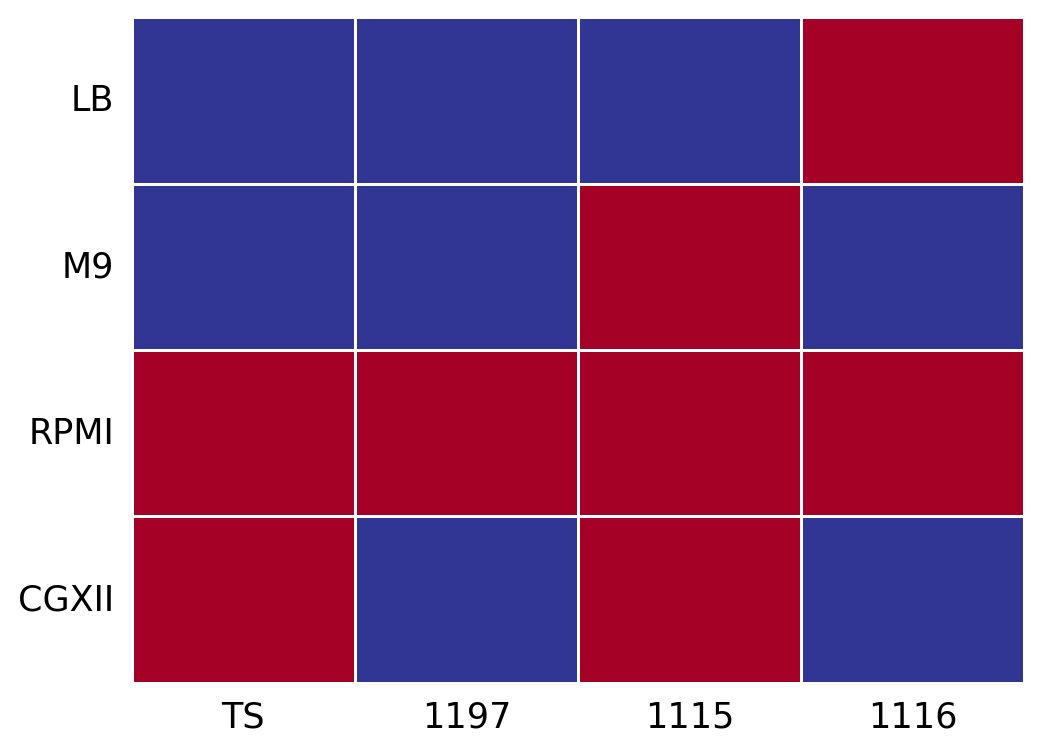

In [37]:
sns.heatmap(con, 
            cmap='RdYlBu', 
            linewidth=.5, 
            cbar=False,
            )
plt.ylabel('')
plt.tick_params(rotation=0, bottom=False, top=False, left=False, right=False)
plt.savefig('../../analysis/comparison/heatmap_binary_comparison.png', bbox_inches='tight')

### Comparison of simulated and measured doubling times

In [32]:
conf = pd.read_excel('/Users/baeuerle/Organisation/Masterarbeit/Nextcloud/master_thesis/paper/Cstr V4/results_V4.xlsx', sheet_name='in silico').replace({'yes':1,'no':0})#.set_index('base')
si = conf[conf['data'] == 'dt [min] (+missing)'].set_index('base').drop('data', axis=1)
conf = pd.read_excel('/Users/baeuerle/Organisation/Masterarbeit/Nextcloud/master_thesis/paper/Cstr V4/results_V4.xlsx', sheet_name='in vitro').replace({'yes':1,'no':0})#.set_index('base')
vi = conf[conf['data'] == 'dt [min] '].set_index('base').drop('data', axis=1)

perc = {}
for medium in ['LB', 'RPMI']:
    perc[medium] = (vi[vi.index == medium]/si[si.index == medium])*100 - 100

df = pd.concat(perc, axis=0)
df.index.names = None, None
df = df.reset_index().drop('level_1',axis=1).set_index('level_0')
df.index.name = None
df

,TS,1197,1115,1116
LB,6.53753,35.941689,-8.76217,-20.229158
RPMI,68.677108,141.915684,120.347795,87.31003


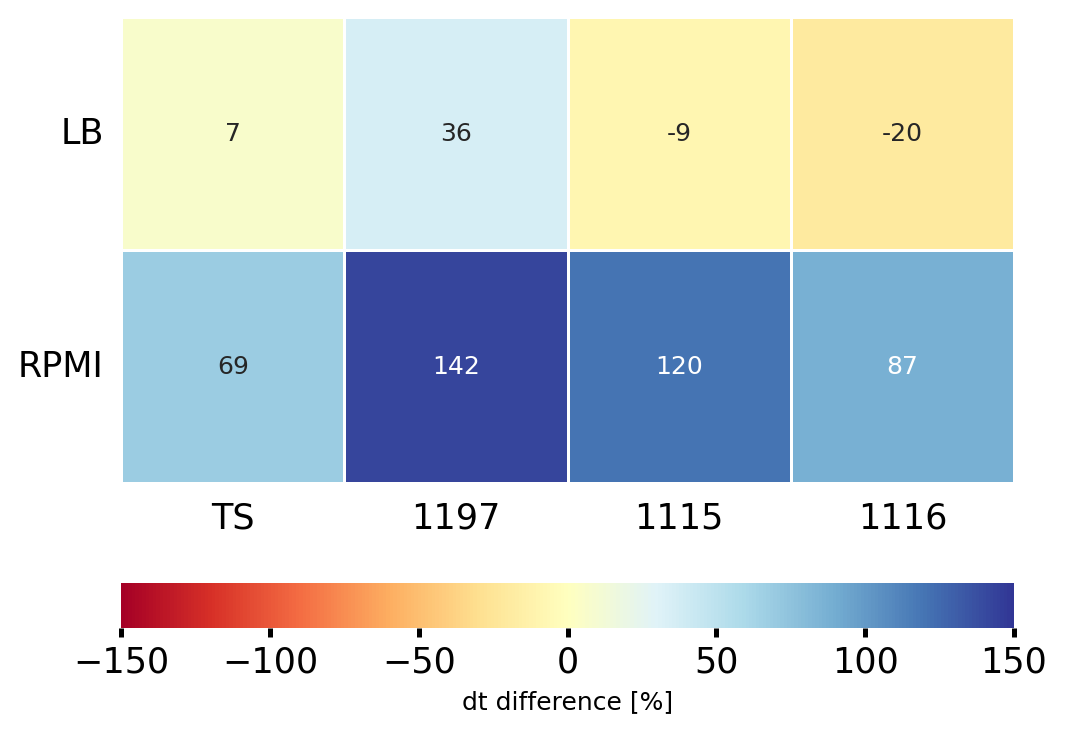

In [33]:
sns.heatmap(df.astype("float"), 
            cmap='RdYlBu', 
            linewidth=.5, 
            vmin = -150,
            vmax = 150,
            annot=True,
            fmt='.0f',
            cbar_kws = {'label':'dt difference [%]','orientation':'horizontal'}
            )
plt.ylabel('')
plt.tick_params(rotation=0, bottom=False, top=False, left=False, right=False)
plt.savefig('../../analysis/comparison/heatmap_dt_comparison.png', bbox_inches='tight')

## Distribution of Reactions over different pathways

Text(0.5, 0, 'Count')

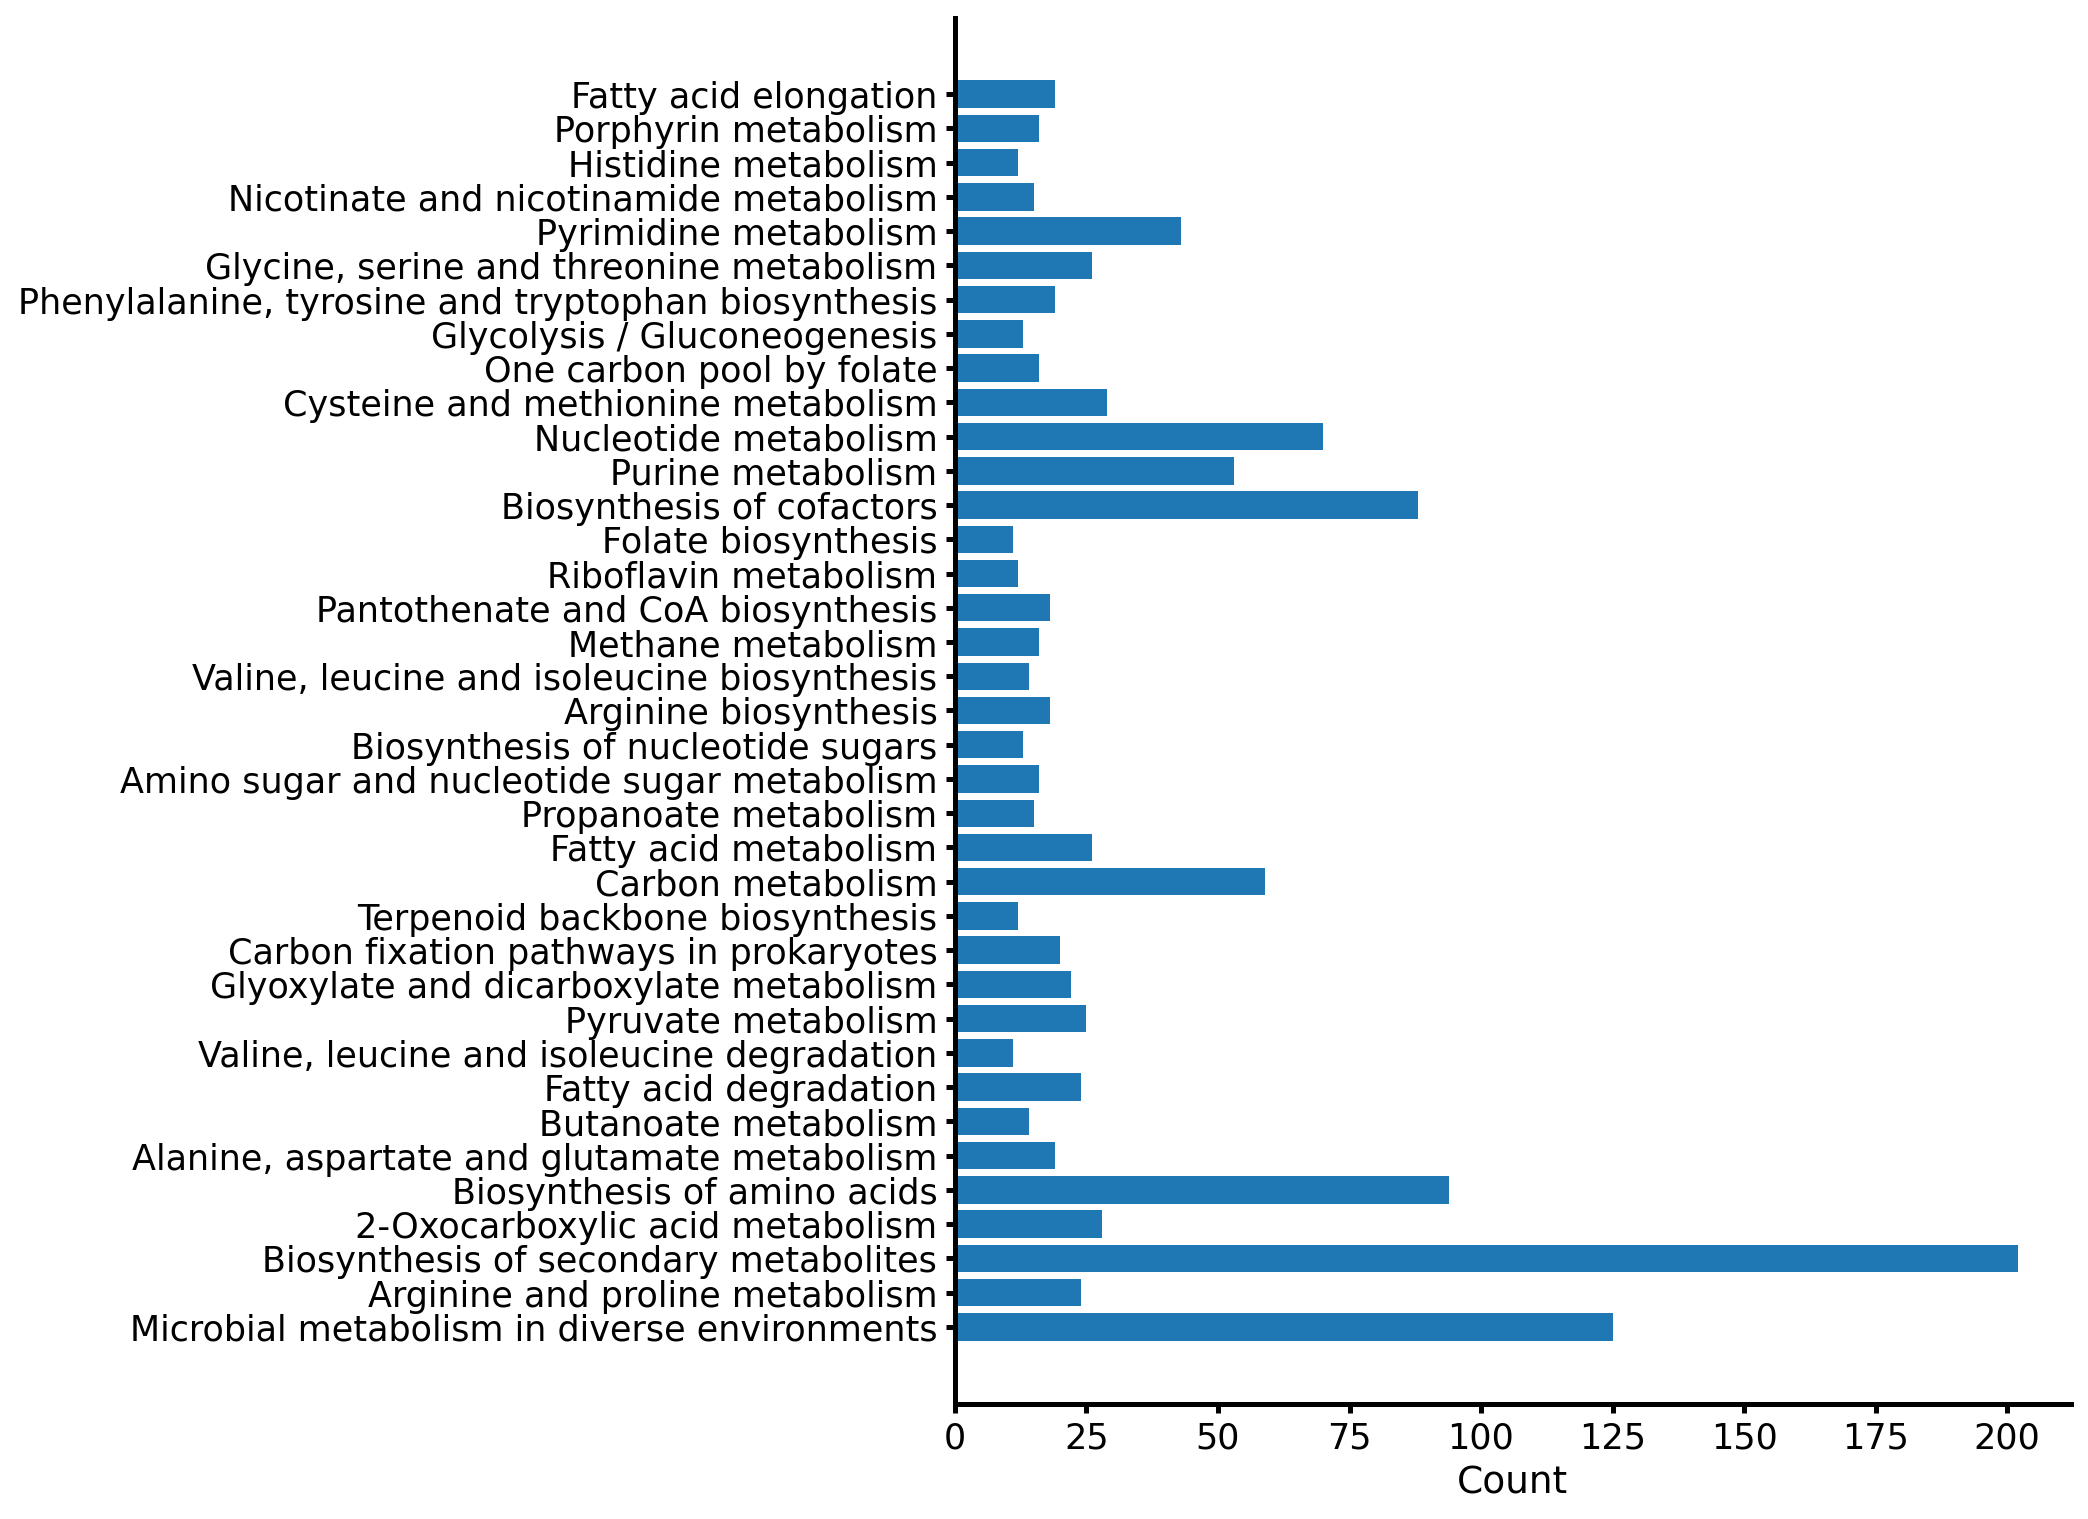

In [43]:
model = mods[0]

groups = {}
for gr in model.getPlugin(1).getListOfGroups():
    groups[gr.getName()] = gr.getNumMembers()

sel = {}
other = 0
for name, value in groups.items():
    if value > 10 and name != 'Metabolic pathways':
        sel[name] = value
    else:
        other = other + value
#sel['Other Pathways'] = other
names = list(sel.keys())
values = list(sel.values())
plt.figure(figsize=(8,10))
plt.barh(range(len(sel)), values, tick_label=names)
plt.xlabel('Count', fontsize=15)